In [76]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import pickle
import sqlite3
import datetime as dt
import ml_insights

import matplotlib.style as style
import matplotlib.patches as mpatches

%matplotlib inline

In [77]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# pickle model for flask app
from sklearn.externals import joblib

In [78]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Getting Data from SQLite Database

In [79]:
con = sqlite3.connect("FPA_FOD_20170508.sqlite")
cur = con.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('spatial_ref_sys',), ('spatialite_history',), ('sqlite_sequence',), ('geometry_columns',), ('spatial_ref_sys_aux',), ('views_geometry_columns',), ('virts_geometry_columns',), ('geometry_columns_statistics',), ('views_geometry_columns_statistics',), ('virts_geometry_columns_statistics',), ('geometry_columns_field_infos',), ('views_geometry_columns_field_infos',), ('virts_geometry_columns_field_infos',), ('geometry_columns_time',), ('geometry_columns_auth',), ('views_geometry_columns_auth',), ('virts_geometry_columns_auth',), ('sql_statements_log',), ('SpatialIndex',), ('ElementaryGeometries',), ('KNN',), ('Fires',), ('idx_Fires_Shape',), ('idx_Fires_Shape_node',), ('idx_Fires_Shape_rowid',), ('idx_Fires_Shape_parent',), ('NWCG_UnitIDActive_20170109',)]


# Visualization for entire dataframe

In [138]:
big_df = pd.read_sql_query("SELECT FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,STAT_CAUSE_DESCR,\
                           STAT_CAUSE_CODE FROM fires", con)

In [139]:
big_cause = big_df['STAT_CAUSE_DESCR'].groupby(big_df['STAT_CAUSE_DESCR']).count().sort_values(ascending=False)

In [140]:
list(big_cause.index)

['Debris Burning',
 'Miscellaneous',
 'Arson',
 'Lightning',
 'Missing/Undefined',
 'Equipment Use',
 'Campfire',
 'Children',
 'Smoking',
 'Railroad',
 'Powerline',
 'Fireworks',
 'Structure']

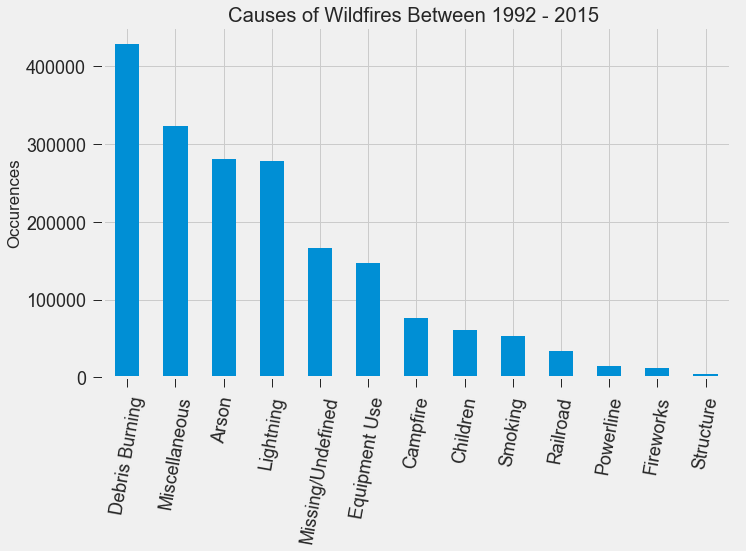

In [141]:
style.use('fivethirtyeight')
plt.figure(figsize = (10,6))

big_cause.plot(kind='bar')
plt.xticks(rotation=80,fontsize=18)
plt.tick_params(axis='both',size=10, labelsize=18)
plt.title('Causes of Wildfires Between 1992 - 2015 ')
plt.xlabel('')
plt.ylabel('Occurences');

In [84]:
def datetime(x):
    return dt.datetime(x,1,1)

def timedelta(x):
    return dt.timedelta(x-1)

def changeday(x):
    return x.replace(day=1)

In [85]:
big_df['TIMESTAMP'] = (big_df['FIRE_YEAR'].apply(datetime) + big_df['DISCOVERY_DOY'].apply(timedelta)).apply(changeday)

In [86]:
count_year = big_df.drop(['FIRE_YEAR',
                          'DISCOVERY_DOY', 
                          'FIRE_SIZE', 
                          'LATITUDE', 
                          'LONGITUDE', 
                          'STATE'], axis=1)
count_year = count_year.groupby(['TIMESTAMP','STAT_CAUSE_DESCR']).count().reset_index()

In [87]:
table = pd.pivot_table(count_year,
                       values=['STAT_CAUSE_CODE'], 
                       index=['TIMESTAMP'],
                       columns=['STAT_CAUSE_DESCR']).reset_index()
table.columns = table.columns.droplevel()

In [88]:
table.columns = ['Year/Month', 'Arson', 'Campfire', 'Children', 'Debris Burning', 'Equipment Use',
       'Fireworks', 'Lightning', 'Miscellaneous', 'Missing/Undefined',
       'Powerline', 'Railroad', 'Smoking', 'Structure']

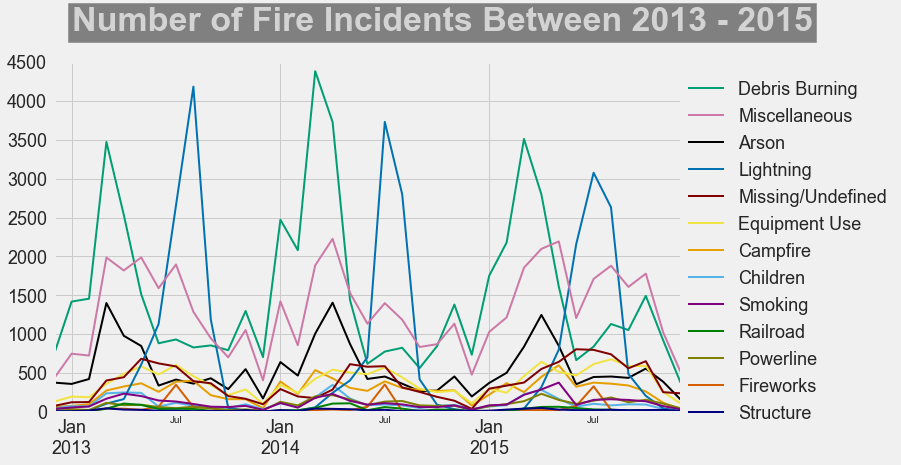

In [89]:
colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255], [240/255,228/255,66/255],
          [213/255,94/255,0], [0,114/255,178/255],[204/255,121/255,167/255],[128/255,0,0],
          [128/255,128/255,0], [0,128/255,0],[128/255,0,128/255],[0,0,128/255]]

cause_graph = table.plot(x = 'Year/Month', figsize = (10,6), color=colors,linewidth=2)

handles,labels = cause_graph.get_legend_handles_labels()
order = [labels.index(x) for x in list(big_cause.index)]
labels = list(big_cause.index)
handles = [handles[x] for x in order]

cause_graph.tick_params(axis = 'both', which = 'major', labelsize = 18)
cause_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
cause_graph.xaxis.label.set_visible(False)
cause_graph.legend(handles,labels,loc=(1,-0.05),fontsize=18)
cause_graph.set_xlim(515,)
cause_graph.set_ylim(0,4500)

plt.text(x = 516, y = 4900, s = "Number of Fire Incidents Between 2013 - 2015",
               fontsize = 34, weight = 'bold', alpha = .75,color = '#f0f0f0', backgroundcolor = 'grey')

In [121]:
avg_fire_size = big_df.groupby('STAT_CAUSE_DESCR')\
.mean().reset_index()\
.drop(['FIRE_YEAR','DISCOVERY_DOY','LATITUDE','LONGITUDE'],axis=1)\
.sort_values(by='FIRE_SIZE',ascending=False)

In [122]:
avg_fire_size

,STAT_CAUSE_DESCR,FIRE_SIZE,STAT_CAUSE_CODE
6,Lightning,312.54,1.00
9,Powerline,111.40,11.00
8,Missing/Undefined,52.49,13.00
4,Equipment Use,46.06,2.00
12,Structure,45.36,12.00
1,Campfire,45.04,4.00
7,Miscellaneous,44.45,9.00
0,Arson,33.71,7.00
5,Fireworks,27.67,10.00
10,Railroad,25.40,6.00


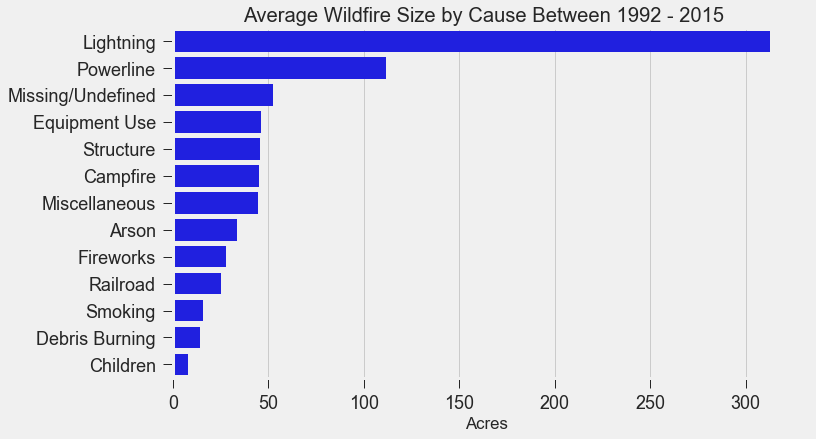

In [127]:
style.use('fivethirtyeight')
plt.figure(figsize = (10,6))

sns.barplot(x='FIRE_SIZE',y='STAT_CAUSE_DESCR',data=avg_fire_size,color='blue')
# plt.xticks(rotation=80,fontsize=18)
plt.tick_params(axis='both',size=10, labelsize=18)
plt.title('Average Wildfire Size by Cause Between 1992 - 2015 ')
plt.xlabel('Acres')
plt.ylabel('');

In [187]:
burn_time_df = pd.read_sql_query("SELECT FIRE_NAME,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,\
                                STATE, CONT_DOY-DISCOVERY_DOY AS DAYS, STAT_CAUSE_CODE, STAT_CAUSE_DESCR FROM Fires \
                                WHERE 0 <= DAYS AND DAYS <= 150", con)

In [193]:
avg_burn_time = burn_time_df.groupby('STAT_CAUSE_DESCR').mean().reset_index()\
.drop(['FIRE_YEAR','DISCOVERY_DOY','CONT_DOY','FIRE_SIZE','LATITUDE','LONGITUDE','STAT_CAUSE_CODE'],axis=1)\
.sort_values(by='DAYS',ascending=False)

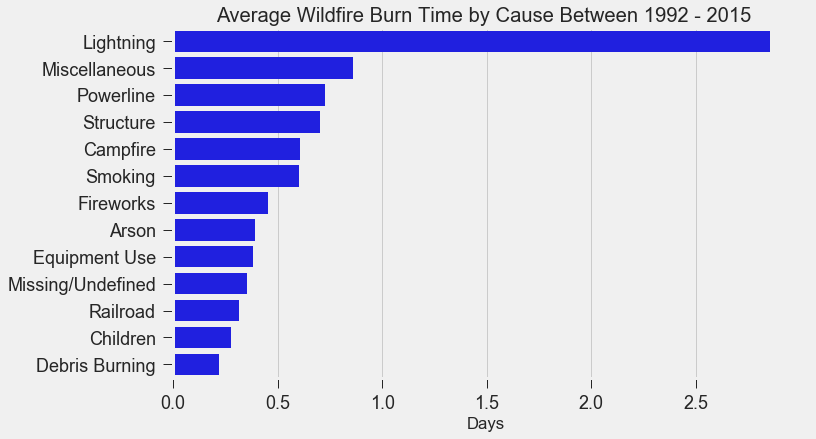

In [198]:
style.use('fivethirtyeight')
plt.figure(figsize = (10,6))

sns.barplot(x='DAYS',y='STAT_CAUSE_DESCR',data=avg_burn_time,color='blue')
# plt.xticks(rotation=80,fontsize=18)
plt.tick_params(axis='both',size=10, labelsize=18)
plt.title('Average Wildfire Burn Time by Cause Between 1992 - 2015 ')
plt.xlabel('Days')
plt.ylabel('')

# d3 Line Graph

In [15]:
line_graph = table[:]

In [16]:
def changetimestamp(x):
    return int(str(x).split()[0].replace('-',''))

In [17]:
line_graph['Year/Month'] = line_graph['Year/Month'].apply(changetimestamp)

In [18]:
line_graph = line_graph.rename(columns={"Year/Month": "date"})

In [19]:
line_graph = line_graph[(line_graph['date'] < 20150500) & (line_graph['date'] > 20130000)]

In [20]:
line_graph = line_graph[['date','Debris Burning','Arson','Lightning','Fireworks','Campfire']]

In [21]:
line_graph.to_csv('line_graph.tsv',sep='\t',index=False)

# Feature Engineering

In [199]:
test_df = pd.read_sql_query("SELECT FIRE_NAME,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,STATE, \
                       CONT_DOY-DISCOVERY_DOY AS DAYS, STAT_CAUSE_CODE, STAT_CAUSE_DESCR FROM Fires", con)

In [203]:
test_df[(test_df['DAYS']<0) | (test_df['DAYS']>150)]

,FIRE_NAME,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,DAYS,STAT_CAUSE_CODE,STAT_CAUSE_DESCR
6473,141,2005,364,3.00,0.30,33.58,-108.73,NM,-361.00,3.00,Smoking
6712,BEAVER DAM,2005,364,1.00,3.60,30.99,-89.13,MS,-363.00,7.00,Arson
6713,WEDGEWORTH,2005,365,1.00,0.10,31.08,-89.07,MS,-364.00,7.00,Arson
17579,MAGGIE,2006,190,345.00,2097.00,36.26,-118.61,CA,155.00,1.00,Lightning
17587,TAMARACK,2006,190,345.00,4654.00,36.32,-118.40,CA,155.00,1.00,Lightning
18301,THE V,2007,1,162.00,5.60,40.91,-111.86,UT,161.00,7.00,Arson
25280,DOMKE,2007,217,7.00,11791.00,48.17,-120.60,WA,-210.00,1.00,Lightning
26509,BIG,2007,364,3.00,0.10,40.74,-123.20,CA,-361.00,9.00,Miscellaneous
27799,CARIBOU,2008,174,351.00,13116.00,41.03,-123.00,CA,177.00,1.00,Lightning
29304,ANTHONY MILNE,2008,189,351.00,1779.00,41.51,-123.18,CA,162.00,1.00,Lightning


In [142]:
df = pd.read_sql_query("SELECT FIRE_NAME,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,STATE, \
                       CONT_DOY-DISCOVERY_DOY AS DAYS, STAT_CAUSE_CODE, STAT_CAUSE_DESCR FROM Fires \
                       WHERE FIRE_YEAR > 2012 AND 0 <= DAYS AND DAYS <= 150", con)
df1 = df[:]

In [143]:
codes = list(zip(df1['STAT_CAUSE_CODE'].unique(),df1['STAT_CAUSE_DESCR'].unique()))
codes.sort(key=lambda x: x[0])

In [144]:
df1.loc[:,'CONT_DOY'].fillna(df1.loc[:,'DISCOVERY_DOY'], inplace=True)
df1.loc[:,'STATE'] = df1.loc[:,'STATE'].replace(list(df1.loc[:,'STATE'].unique())
                                               ,range(len(list(df1.loc[:,'STATE'].unique()))))
df1['GEOMETRY'] = df1.apply(lambda x: Point((float(x.LONGITUDE), float(x.LATITUDE))), axis=1)

/Users/kennyleung/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [145]:
with open('fire.pkl', 'wb') as fp:
    pickle.dump(df1, fp)

In [146]:
sorted_cause = df1['STAT_CAUSE_DESCR'].groupby(df1['STAT_CAUSE_DESCR']).count().sort_values(ascending=False)

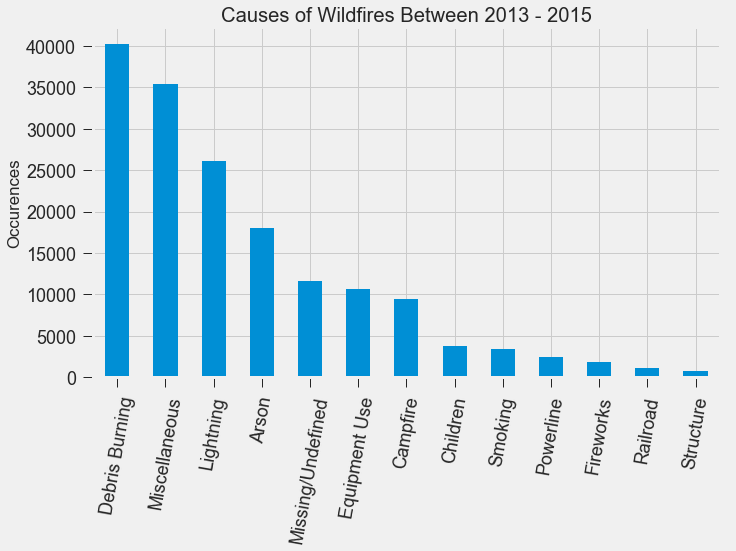

In [147]:
style.use('fivethirtyeight')
plt.figure(figsize = (10,6))

sorted_cause.plot(kind='bar')
plt.xticks(rotation=80,fontsize=18)
plt.tick_params(axis='both',size=10, labelsize=18)
plt.title('Causes of Wildfires Between 2013 - 2015')
plt.xlabel('')
plt.ylabel('Occurences');

In [148]:
X = df1.loc[:,['FIRE_YEAR','DISCOVERY_DOY','DAYS','FIRE_SIZE','LATITUDE','LONGITUDE','STATE']]
y = df1.loc[:,'STAT_CAUSE_CODE']

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [150]:
X_train['FIRE_SIZE'].mean()

98.90154377706827

In [151]:
print(X_train.shape)
print(X_test.shape)

(115411, 7)
(49463, 7)


# Standardize data for Logistic Regression and KNN model

In [32]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)

# Logistic Regression model

In [36]:
codes

[(1.0, 'Lightning'),
 (2.0, 'Equipment Use'),
 (3.0, 'Smoking'),
 (4.0, 'Campfire'),
 (5.0, 'Debris Burning'),
 (6.0, 'Railroad'),
 (7.0, 'Arson'),
 (8.0, 'Children'),
 (9.0, 'Miscellaneous'),
 (10.0, 'Fireworks'),
 (11.0, 'Powerline'),
 (12.0, 'Structure'),
 (13.0, 'Missing/Undefined')]

In [34]:
log = LogisticRegression()
log.fit(X_tr,y_train)
log_pred = log.predict(X_te)

print(log)
print('Accuracy: ',accuracy_score(y_test,log_pred))
print('Precision: ',precision_score(y_test,log_pred,average='macro'))
print('Recall: ',recall_score(y_test,log_pred,average='macro'))
print('f1: ',f1_score(y_test,log_pred,average='macro'))
print('Confusion Matrix: \n',confusion_matrix(y_test,log_pred))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy:  0.379253179144
Precision:  0.116424848857
Recall:  0.169754932133
f1:  0.133539353251
Confusion Matrix: 
 [[5808    0    0    0 1162    0    0    0  309    0    0    0  513]
 [ 813    0    0    0 1448    0    0    0  654    0    0    0  263]
 [ 191    0    0    0  614    0    0    0  192    0    0    0   48]
 [1112    0    0    0 1240    0    0    0  259    0    0    0  179]
 [ 992    0    0    0 9117    0    0    0 1625    0    0    0  255]
 [  56    0    0    0  198    0    0    0   63    0    0    0    2]
 [ 721    0    0    0 3388    0    0    0 1196    0    0    0  173]
 [ 173    0    0    0  685    0    0    0  199    0    0    0   62]
 [2328    0    0    0 5511    0    0    0 2070    0    0    0  837]
 [ 231

/Users/kennyleung/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kennyleung/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
log.coef_

array([[ -7.68706000e-02,   4.51256447e-01,   2.31740100e-01,
          9.31563456e-02,   1.98046567e-01,  -5.21074294e-01,
         -4.57828657e-01],
       [  2.95073663e-02,   1.30543111e-01,  -2.36635783e-01,
          1.85323744e-02,   9.50739951e-02,  -2.62847567e-02,
          1.09062599e-01],
       [  2.11928670e-02,  -4.08532041e-02,   2.25008415e-02,
         -1.92344824e+00,   2.49837235e-01,   2.74465706e-01,
          3.40573975e-01],
       [  5.28987175e-02,   5.52572206e-04,  -1.82104372e-01,
         -1.05624471e+00,   2.33663725e-01,   1.15814849e-01,
         -2.74176218e-01],
       [ -1.27343659e-02,  -2.93962037e-01,  -5.88933450e-01,
         -5.08798703e-01,  -2.01360258e-01,   6.53503576e-01,
         -7.36880087e-02],
       [ -1.48892185e-01,  -1.74808549e-02,  -3.22443465e-01,
         -3.80995500e-01,   5.11880444e-01,   6.30684725e-01,
          6.83309863e-02],
       [ -1.14623404e-01,  -9.58939005e-02,  -5.50074270e-02,
         -3.70766533e-02,  -2.85

# Finding the best k-value for KNN

In [389]:
error_rate = []

for i in range(1,20):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_tr,y_train)
    pred_i = knn.predict(X_te)
    error_rate.append(np.mean(pred_i != y_test))

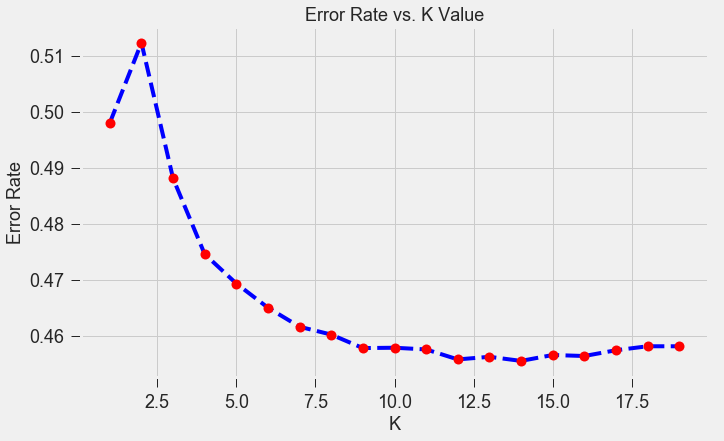

In [390]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)

plt.title('Error Rate vs. K Value',fontsize=18)
plt.tick_params(axis='both',size=10, labelsize=18)
plt.xlabel('K',fontsize=18)
plt.ylabel('Error Rate',fontsize=18);

# GridSearchCV for RandomForestClassifier

In [393]:
parameters = {'n_estimators':[500,600,700],
              'max_features':[3],
              'min_samples_leaf':[3,4]}

model = RandomForestClassifier()
grid_search = GridSearchCV(model, parameters, n_jobs=-2, verbose=1)
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-2)]: Done  18 out of  18 | elapsed: 14.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'n_estimators': [500, 600, 700], 'max_features': [3], 'min_samples_leaf': [3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [394]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# GridSearchCV for GradientBoostingClassifier

In [367]:
parameters = {'subsample':np.arange(.5,1,.2),
              'max_depth':[1],
              'learning_rate':np.arange(.05,.1,.02),
              'n_estimators':[500]}

model = GradientBoostingClassifier()
grid_search = GridSearchCV(model, parameters, n_jobs=-2, verbose=1)
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-2)]: Done  27 out of  27 | elapsed: 41.1min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'subsample': array([ 0.5,  0.7,  0.9]), 'max_depth': [1], 'learning_rate': array([ 0.05,  0.07,  0.09]), 'n_estimators': [500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [368]:
grid_search.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.090000000000000011, loss='deviance',
              max_depth=1, max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [781]:
codes

[(1.0, 'Lightning'),
 (2.0, 'Equipment Use'),
 (3.0, 'Smoking'),
 (4.0, 'Campfire'),
 (5.0, 'Debris Burning'),
 (6.0, 'Railroad'),
 (7.0, 'Arson'),
 (8.0, 'Children'),
 (9.0, 'Miscellaneous'),
 (10.0, 'Fireworks'),
 (11.0, 'Powerline'),
 (12.0, 'Structure'),
 (13.0, 'Missing/Undefined')]

# KNN model

In [513]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_tr,y_train)
knn_pred = knn.predict(X_te)

print(knn)
print('Accuracy: ',accuracy_score(y_test,knn_pred))
print('Precision: ',precision_score(y_test,knn_pred,average='macro'))
print('Recall: ',recall_score(y_test,knn_pred,average='macro'))
print('f1: ',f1_score(y_test,knn_pred,average='macro'))
print('Confusion Matrix: \n',confusion_matrix(y_test,knn_pred))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=12, p=2,
           weights='uniform')
Accuracy:  0.540868932333
Precision:  0.409092476084
Recall:  0.324309426678
f1:  0.340337910161
Confusion Matrix: 
 [[6502   88   19  144  268    2   90   10  604   21    7    0   82]
 [ 324  561   17   86  918    7  241   26  732   28   10    0  163]
 [  59   73   64   38  280    1   48   15  430    4    0    0   52]
 [ 478  139   11  764  735    3  127    8  405   13    8    0  119]
 [ 340  368   22  363 8729   24  841   63 1252   28   16    2  183]
 [  30   32    0   25  135   61   17    1   28    1    2    0    1]
 [ 267  159   22  101 1751    5 1891   81 1033   21    9    0  144]
 [  73   52    9   31  428    1  147  118  174   12    2    0   41]
 [ 860  422   82  320 2046   10  545   62 5662   48   12    0  502]
 [  71   37    1   15  115    3   31    6   87  160    1    0    8]
 [ 107   74    0   24  250    3   55  

# Decision Tree model

In [27]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
dtree_pred = dtree.predict(X_test)

print(dtree)
print('Accuracy: ',accuracy_score(y_test,dtree_pred))
print('Precision: ',precision_score(y_test,dtree_pred,average='macro'))
print('Recall: ',recall_score(y_test,dtree_pred,average='macro'))
print('f1: ',f1_score(y_test,dtree_pred,average='macro'))
print('Confusion Matrix: \n',confusion_matrix(y_test,dtree_pred))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy:  0.488365040535
Precision:  0.3415096048
Recall:  0.346436274552
f1:  0.343840515224
Confusion Matrix: 
 [[5682  267   69  333  295   25  200   46  616   35   61   10  164]
 [ 225  751   86  135  666   26  252   83  696   54   87   23  135]
 [  60   70  141   48  196    6   70   33  331   14   15    3   45]
 [ 296  154   60  961  583   20  172   56  433   18   29    8   67]
 [ 286  692  237  554 6509   83 1172  329 1577   86  178   68  182]
 [  16   23    8   23   65  112   26    6   34    2    5    2    3]
 [ 171  256   93  151 1153   21 2271  166  838   54   60   46  123]
 [  55   69   35   51  292    3  206  177  186   19   12   

In [30]:
list(zip(X_train.columns,dtree.feature_importances_))

[('FIRE_YEAR', 0.041874044155131809),
 ('DISCOVERY_DOY', 0.1921587276579837),
 ('DAYS', 0.041044337944612201),
 ('FIRE_SIZE', 0.097829305015094709),
 ('LATITUDE', 0.25572795028266965),
 ('LONGITUDE', 0.30517270130904373),
 ('STATE', 0.066192933635464135)]

# Random Forest Classifier model

In [27]:
randf = RandomForestClassifier(max_features=3,min_samples_leaf=3,n_estimators=600)
randf.fit(X_train,y_train)
randf_pred = randf.predict(X_test)

print(randf)
print('Accuracy: ',accuracy_score(y_test,randf_pred))
print('Precision: ',precision_score(y_test,randf_pred,average='macro'))
print('Recall: ',recall_score(y_test,randf_pred,average='macro'))
print('f1: ',f1_score(y_test,randf_pred,average='macro'))
print('Confusion Matrix: \n',confusion_matrix(y_test,randf_pred))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy:  0.594201726543
Precision:  0.518808152011
Recall:  0.362396268162
f1:  0.386567100152
Confusion Matrix: 
 [[6610   54    3  119  282    0   65    5  555   12    7    0   45]
 [ 310  601   10   94 1010    2  207   14  820   25    9    1  171]
 [  41   43   61   36  273    1   45   10  432    6    1    0   69]
 [ 410   50    8 1002  748    1   84    9  444   14    4    0   63]
 [ 225  198    9  274 9282    1  670   35 1201   23   16    1  172]
 [  28   19    4   18  124   65   18    1   24    2    0    0    1]
 [ 168   88    7   46 1535    1 2327   82 1028   16    6  

In [1023]:
joblib.dump(randf,'randf.pkl')

['randf.pkl']

In [68]:
randf = joblib.load('randf.pkl') 

In [78]:
randf_prob = randf.predict_proba(X_test)

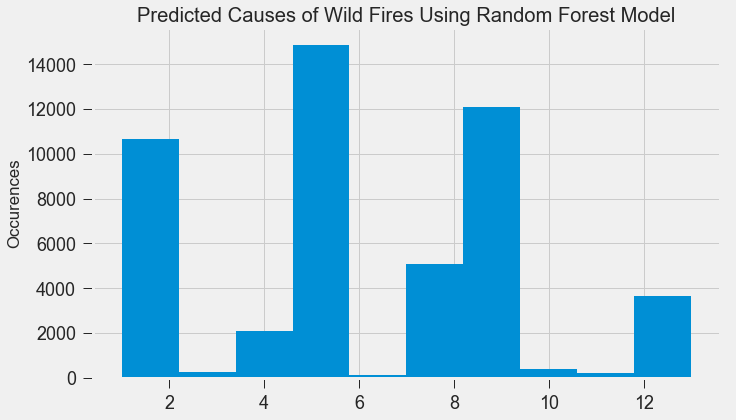

In [76]:
# style.use('fivethirtyeight')
plt.figure(figsize = (10,6))

plt.hist(list(randf_pred))
# plt.xticks(rotation=80,fontsize=18)
plt.tick_params(axis='both',size=10, labelsize=18)
plt.title('Predicted Causes of Wild Fires Using Random Forest Model')
plt.xlabel('')
plt.ylabel('Occurences');

## ML-insights

In [1]:
# model_insight = ml_insights.ModelXRay(randf,X_test[:10])
# model_insight.feature_dependence_plots();

In [517]:
list(zip(X_train.columns,randf.feature_importances_))

[('FIRE_YEAR', 0.042835291685373915),
 ('DISCOVERY_DOY', 0.18433129294440539),
 ('DAYS', 0.046805350734576485),
 ('FIRE_SIZE', 0.088175800779679986),
 ('LATITUDE', 0.24295951722319803),
 ('LONGITUDE', 0.28649554046770748),
 ('STATE', 0.10839720616505863)]

# Gradient Boosting Classifier model

In [519]:
gboost = GradientBoostingClassifier(learning_rate=0.1,max_depth=1,subsample=0.5,n_estimators=500)
gboost.fit(X_train,y_train)
gboost_pred = gboost.predict(X_test)

print(gboost)
print('Accuracy: ',accuracy_score(y_test,gboost_pred))
print('Precision: ',precision_score(y_test,gboost_pred,average='macro'))
print('Recall: ',recall_score(y_test,gboost_pred,average='macro'))
print('f1: ',f1_score(y_test,gboost_pred,average='macro'))
print('Confusion Matrix: \n',confusion_matrix(y_test,gboost_pred))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)
Accuracy:  0.511412571013
Precision:  0.380560564452
Recall:  0.259212831404
f1:  0.255659991302
Confusion Matrix: 
 [[6499   10    0   29  328    0   73    1  767   15    0    0  115]
 [ 546   48    0   22 1174    1  110    0 1034   19    0    0  159]
 [  86    1    0   12  314    0   16    0  590    3    0    0   42]
 [ 763   16    0  235 1007    1   39    2  579   17    0    0  151]
 [ 460   13    0   70 9542    2  342    9 1608   16    1    0  168]
 [  48    7    0    1  194   14    7    0   57    5    0    0    0]
 [ 3

/Users/kennyleung/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kennyleung/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [520]:
list(zip(X_train.columns,gboost.feature_importances_))

[('FIRE_YEAR', 0.013846153846153836),
 ('DISCOVERY_DOY', 0.099538461538461964),
 ('DAYS', 0.030769230769230705),
 ('FIRE_SIZE', 0.055384615384615248),
 ('LATITUDE', 0.2041538461538468),
 ('LONGITUDE', 0.28923076923076996),
 ('STATE', 0.30707692307692408)]

# Results

In [521]:
accuracy_scores = [accuracy_score(y_test,randf_pred),accuracy_score(y_test,knn_pred),
                   accuracy_score(y_test,gboost_pred),accuracy_score(y_test,dtree_pred)]
precision_scores = [precision_score(y_test,randf_pred,average='macro'),precision_score(y_test,knn_pred,average='macro'),
                    precision_score(y_test,gboost_pred,average='macro'),precision_score(y_test,dtree_pred,average='macro')]
recall_scores = [recall_score(y_test,randf_pred,average='macro'),recall_score(y_test,knn_pred,average='macro'),
                 recall_score(y_test,gboost_pred,average='macro'),recall_score(y_test,dtree_pred,average='macro')]
f1_scores = [f1_score(y_test,randf_pred,average='macro'),f1_score(y_test,knn_pred,average='macro'),
             f1_score(y_test,gboost_pred,average='macro'),f1_score(y_test,dtree_pred,average='macro')]

/Users/kennyleung/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kennyleung/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


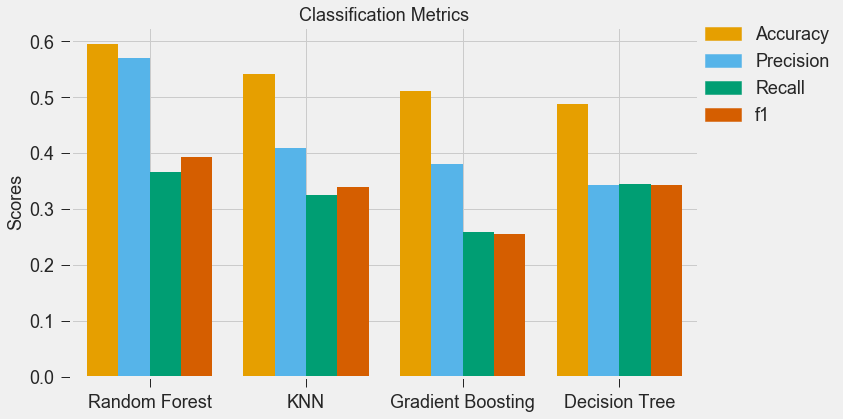

In [527]:
style.use('fivethirtyeight')

pos = list(range(4)) 
width = 0.20 

fig, ax = plt.subplots(figsize=(10,6))

blue_patch = mpatches.Patch(color=colors[1], label='Accuracy')
red_patch = mpatches.Patch(color=colors[2], label='Precision')
green_patch = mpatches.Patch(color=colors[3], label='Recall')
yellow_patch = mpatches.Patch(color=colors[5], label='f1')

plt.legend(handles=[blue_patch,red_patch,green_patch,yellow_patch,],prop={'size': 18},loc=(1,0.7))

plt.bar(pos, accuracy_scores, width, color=colors[1], label='Accuracy Score')
plt.bar([p + width for p in pos], precision_scores, width, color=colors[2], label='Precision Score') 
plt.bar([p + width*2 for p in pos], recall_scores, width, color=colors[3], label='Recall Score')
plt.bar([p + width*3 for p in pos], f1_scores, width, color=colors[5], label='f1 Score')

ax.set_ylabel('Scores',fontsize=18)
ax.set_title('Classification Metrics',fontsize=18)
ax.set_xticks([p + 1.5 * width for p in pos])
plt.tick_params(axis='both',size=10, labelsize=18)
plt.xlim(min(pos)-width, max(pos)+width*4)
ax.set_xticklabels(['Random Forest','KNN','Gradient Boosting','Decision Tree'],fontsize=18);

In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    plt.colorbar(shrink=0.75)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12, rotation='vertical')
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel('Actual label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)

Confusion matrix, without normalization
Normalized confusion matrix


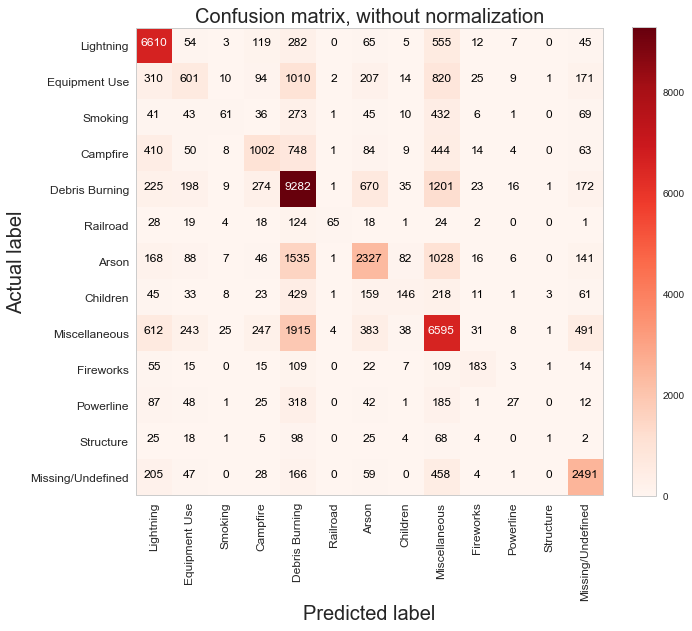

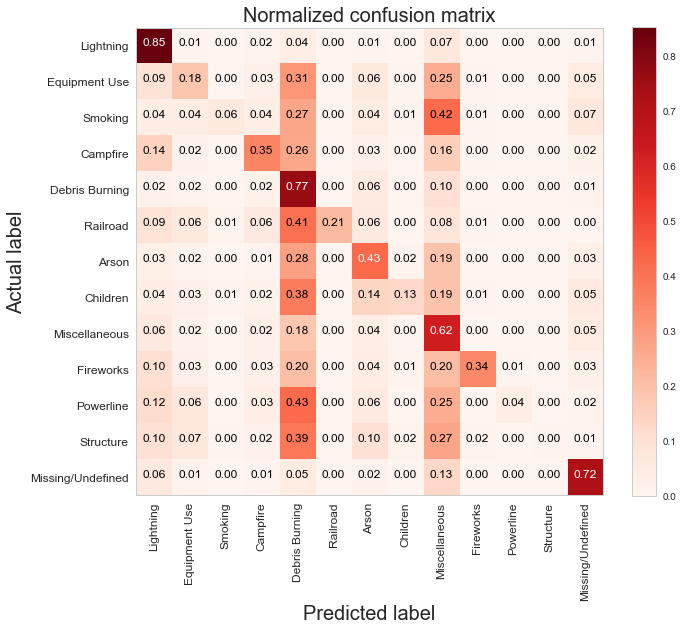

In [49]:
class_names = [x[1] for x in codes]
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,randf_pred);
np.set_printoptions(precision=2)

sns.set_style("whitegrid", {'axes.grid' : False})
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization');

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix');

# Predicting the cause for Missing/Unidentified cases

In [204]:
df_predicting = pd.read_sql_query("SELECT FIRE_NAME,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE, \
                                    STATE,CONT_DOY-DISCOVERY_DOY AS DAYS, STAT_CAUSE_CODE, STAT_CAUSE_DESCR \
                                    FROM Fires WHERE 0 <= DAYS AND DAYS <= 150", con)

In [205]:
df_predicting.loc[:,'CONT_DOY'].fillna(df_predicting.loc[:,'DISCOVERY_DOY'], inplace=True)
df_predicting.loc[:,'STATE'] = df_predicting.loc[:,'STATE'].replace(list(df_predicting.loc[:,'STATE'].unique())
                                               ,range(len(list(df_predicting.loc[:,'STATE'].unique()))))

In [40]:
df_missing = df_predicting[df_predicting['STAT_CAUSE_DESCR'] == 'Missing/Undefined']
df_defined = df_predicting[df_predicting['STAT_CAUSE_DESCR'] != 'Missing/Undefined']

In [41]:
len(df_missing), len(df_defined)

(71529, 916703)

In [42]:
X_defined = df_defined.loc[:,['FIRE_YEAR','DISCOVERY_DOY','DAYS','FIRE_SIZE','LATITUDE','LONGITUDE','STATE']]
y_defined = df_defined.loc[:,'STAT_CAUSE_CODE']
X_missing = df_missing.loc[:,['FIRE_YEAR','DISCOVERY_DOY','DAYS','FIRE_SIZE','LATITUDE','LONGITUDE','STATE']]

In [10]:
randf_miss = RandomForestClassifier(max_features=3,min_samples_leaf=3,n_estimators=600)
randf_miss.fit(X_defined,y_defined)
randf_miss_pred = randf_miss.predict(X_missing)

In [12]:
joblib.dump(randf_miss,'randf_miss.pkl')

['randf_miss.pkl']

In [854]:
list(zip(X_defined.columns,randf_miss.feature_importances_))

[('FIRE_YEAR', 0.098550203643457984),
 ('DISCOVERY_DOY', 0.18333288414115498),
 ('DAYS', 0.038134350625315776),
 ('FIRE_SIZE', 0.077587435268205246),
 ('LATITUDE', 0.212132952087591),
 ('LONGITUDE', 0.2929615509880118),
 ('STATE', 0.097300623246262846)]

In [855]:
causes = [dict(codes)[x] for x in list(randf_miss_pred)]

In [856]:
causes_df = pd.DataFrame(causes,columns=["Cause"])

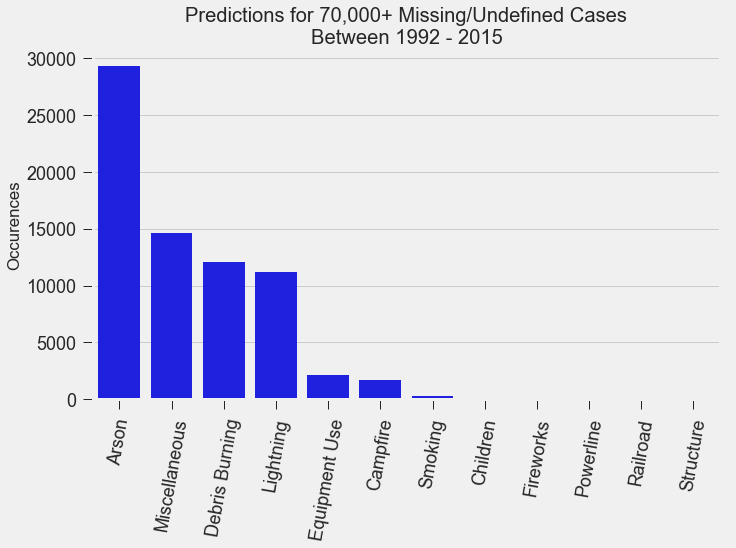

In [1008]:
style.use('fivethirtyeight')
plt.figure(figsize=(10,6))

sns.countplot(causes_df['Cause'],order = causes_df['Cause'].value_counts().index, color='blue')
plt.xticks(rotation=80,fontsize=18)
plt.tick_params(axis='both',size=10, labelsize=18)
plt.title('Predictions for 70,000+ Missing/Undefined Cases\nBetween 1992 - 2015')
plt.xlabel('')
plt.ylabel('Occurences');

# Removing Missing/Undefined Cases for Flask App

In [68]:
df_flask = pd.read_sql_query("SELECT FIRE_NAME,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE, \
                            STATE,CONT_DOY-DISCOVERY_DOY AS DAYS, STAT_CAUSE_CODE, STAT_CAUSE_DESCR \
                            FROM Fires WHERE FIRE_YEAR > 2012 AND 0 <= DAYS AND DAYS <= 150", con)

In [69]:
df_flask.loc[:,'CONT_DOY'].fillna(df_flask.loc[:,'DISCOVERY_DOY'], inplace=True)
df_flask.loc[:,'STATE'] = df_flask.loc[:,'STATE'].replace(list(df_flask.loc[:,'STATE'].unique())
                                               ,range(len(list(df_flask.loc[:,'STATE'].unique()))))

In [70]:
df_missing_flask = df_flask[df_flask['STAT_CAUSE_DESCR'] == 'Missing/Undefined']
df_defined_flask = df_flask[df_flask['STAT_CAUSE_DESCR'] != 'Missing/Undefined']

In [72]:
len(df_missing_flask), len(df_defined_flask)

(11630, 153244)

In [73]:
X_defined_flask = df_defined_flask.loc[:,['FIRE_YEAR','DISCOVERY_DOY','DAYS','FIRE_SIZE','LATITUDE','LONGITUDE','STATE']]
y_defined_flask = df_defined_flask.loc[:,'STAT_CAUSE_CODE']
X_missing_flask = df_missing_flask.loc[:,['FIRE_YEAR','DISCOVERY_DOY','DAYS','FIRE_SIZE','LATITUDE','LONGITUDE','STATE']]

In [74]:
randf_miss_flask = RandomForestClassifier(max_features=3,min_samples_leaf=3,n_estimators=600)
randf_miss_flask.fit(X_defined_flask,y_defined_flask)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [75]:
joblib.dump(randf_miss_flask,'randf_miss_flask.pkl')

['randf_miss_flask.pkl']

# GeoPandas Map

In [8]:
shp_fn = '/Users/kennyleung/_ds/metis/metisgh/proj3-mcnulty/cb_2016_us_state_500k/cb_2016_us_state_500k.shp'

In [ ]:
counties = gpd.read_file(shp_fn)

In [ ]:
crs = {'init': 'epsg:3395'}
geometry = [Point(xy) for xy in zip(df1.LONGITUDE, df1.LATITUDE)]

In [ ]:
geop = df1.loc[:,['FIRE_YEAR','DISCOVERY_DOY','DAYS','FIRE_SIZE','STATE']]
fire = gpd.GeoDataFrame(geop,crs=crs,geometry=geometry)

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))#,subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_aspect('equal')

water = 'lightskyblue'
earth = 'cornsilk'

ax.set_facecolor(water)

counties.plot(ax=ax, edgecolor='grey',facecolor=earth,linewidth=1, alpha=1)

plt.xlim(-130,-65);
plt.ylim(24,50);

fire[fire.FIRE_YEAR>=2013].plot(ax=ax, color='red', marker='o', markersize=5,alpha=0.2)

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))
ax.set_aspect('equal')

water = 'lightskyblue'
earth = 'cornsilk'

ax.set_facecolor(water)
counties.plot(ax=ax, edgecolor='grey',facecolor=earth,linewidth=1, alpha=1)
plt.xlim(-180,-125);
plt.ylim(50,73);

fire[fire.FIRE_YEAR>=2013].plot(ax=ax,color='red', marker='o', markersize=5,alpha=0.2)

# d3 Map

d3 code from https://vida.io/gists/ot4Ynw4gZdmKkofo8

In [171]:
df_viz = pd.read_sql_query("SELECT FIRE_NAME,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,STATE, \
                       CONT_DOY-DISCOVERY_DOY AS DAYS, STAT_CAUSE_CODE, STAT_CAUSE_DESCR FROM Fires \
                       WHERE 0 <= DAYS AND DAYS <= 150", con)

In [172]:
df_viz_all = df_viz[:] #[df_viz['FIRE_YEAR'] == 2015]
df_viz_all = df_viz_all[['STATE','FIRE_SIZE']].groupby('STATE').sum().reset_index()
df_viz_all['FIRE_SIZE'] = df_viz_all['FIRE_SIZE'].apply(lambda x : x*0.404686)

states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

df_viz_all['STATE'] = df_viz_all['STATE'].apply(lambda x: states[x])
df_viz_all = df_viz_all[['STATE','FIRE_SIZE']]

In [173]:
# web scrape for state size
import requests
from bs4 import BeautifulSoup

In [174]:
url = 'http://www.ipl.org/div/stateknow/popchart.html'

response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, "lxml")

In [175]:
column_headers = soup.find(class_='sk_sizechart').findAll('tr')[0].getText().split()[:3]
data_rows = soup.find(class_='sk_sizechart').findAll('tr')[2:]
data = [[td.getText() for td in data_rows[i].findAll('td')] for i in range(len(data_rows))]

state_size = pd.DataFrame(data, columns=column_headers)
state_size['State'].replace('Washington, D. C.','District of Columbia',inplace=True)
state_size = state_size.rename(columns = {'Size(land':'Area (sq miles)'})

In [176]:
df_viz_all = df_viz_all.merge(state_size,how='inner',left_on='STATE', right_on='State')
df_viz_all['STATE_SIZE'] = df_viz_all['Area (sq miles)'].apply(lambda x: float(x.replace(',','')))
df_viz_all['STATE_SIZE'] = df_viz_all['STATE_SIZE'].apply(lambda x: x*259)
df_viz_all['% of State Area Burned'] = 100*df_viz_all['FIRE_SIZE']/df_viz_all['STATE_SIZE']
df_viz_all = df_viz_all.round({'FIRE_SIZE': 0, 'STATE_SIZE': 2, '% of State Area Burned':2})
df_viz_all = df_viz_all[['STATE','FIRE_SIZE','STATE_SIZE','% of State Area Burned']]

In [177]:
# create a log scale column used for d3 map colors
def perclog(x):
    if x < 0.0000000001:
        return 0
    else:
        return np.log(x*100)

In [178]:
df_viz_all['logScale'] = df_viz_all['% of State Area Burned'].apply(perclog)

In [179]:
df_viz_all.to_csv('df_viz_all.csv')

In [180]:
df_all = df_viz[:]

In [181]:
fire_size_all = df_all[['FIRE_YEAR','STATE','FIRE_SIZE']].groupby(['FIRE_YEAR','STATE']).sum().reset_index()

In [182]:
fire_size_all['FIRE_SIZE'] = fire_size_all['FIRE_SIZE'].apply(lambda x : x*0.404686)

states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

fire_size_all['STATE'] = fire_size_all['STATE'].apply(lambda x: states[x])

In [183]:
fire_size_all = fire_size_all.merge(state_size,how='inner',left_on='STATE', right_on='State')
fire_size_all['STATE_SIZE'] = fire_size_all['Area (sq miles)'].apply(lambda x: float(x.replace(',','')))
fire_size_all['STATE_SIZE'] = fire_size_all['STATE_SIZE'].apply(lambda x: x*259)
fire_size_all['% of State Area Burned'] = 100*fire_size_all['FIRE_SIZE']/fire_size_all['STATE_SIZE']
fire_size_all = fire_size_all.round({'FIRE_SIZE': 2, 'STATE_SIZE': 2, '% of State Area Burned':2})

In [184]:
fire_size_all = fire_size_all[['FIRE_YEAR','STATE','FIRE_SIZE','STATE_SIZE','% of State Area Burned']]

In [185]:
fire_size_all.to_csv('fire_size_all.csv')

# Save dataframe to JSON format for d3 map

In [61]:
big_df = pd.read_sql_query("SELECT FIRE_YEAR,FIRE_SIZE,STATE FROM Fires", con)

In [27]:
prep = big_df.pivot_table(index= 'STATE', columns= 'FIRE_YEAR')

In [28]:
prep.to_json('data.json')

# Flask App

In [67]:
latlong_df = pd.read_sql_query("SELECT FIRE_SIZE,LATITUDE,LONGITUDE FROM Fires WHERE FIRE_YEAR > 2013", con)

In [68]:
latlong_df.to_csv('latlong.csv')